# Evaluating delay - FH only - DU at HL3

In [34]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

green = "#115e67"
yellow = "#f0b434"
def setBoxColors(bp):
    if len(bp['boxes']) > 0:
        plt.setp(bp['boxes'][0], color=green)
    if len(bp['caps']) > 1:
        plt.setp(bp['caps'][0], color=green)
        plt.setp(bp['caps'][1], color=green)
    if len(bp['whiskers']) > 1:
        plt.setp(bp['whiskers'][0], color=green)
        plt.setp(bp['whiskers'][1], color=green)
    if len(bp['fliers']) > 1:
        plt.setp(bp['fliers'][0], color=green)
        plt.setp(bp['fliers'][1], color=green)
    if len(bp['medians']) > 0:
        plt.setp(bp['medians'][0], color=green)
        plt.setp(bp['means'][0], marker='o', markerfacecolor=green, markeredgecolor=green, markersize=8)
        
    if len(bp['boxes']) > 1:
        plt.setp(bp['boxes'][1], color=yellow)
    if len(bp['caps']) > 3:
        plt.setp(bp['caps'][2], color=yellow)
        plt.setp(bp['caps'][3], color=yellow)
    if len(bp['whiskers']) > 3:
        plt.setp(bp['whiskers'][2], color=yellow)
        plt.setp(bp['whiskers'][3], color=yellow)
    if len(bp['fliers']) > 3:
        plt.setp(bp['fliers'][2], color=yellow)
        plt.setp(bp['fliers'][3], color=yellow)
    if len(bp['medians']) > 1:
        plt.setp(bp['medians'][1], color=yellow)
        plt.setp(bp['means'][1], marker='o', markerfacecolor=yellow, markeredgecolor=yellow, markersize=8)
    

MTU: 8000, DU: hl4, Max-Min delay: 0.18 us, Avg. delay 227.80 us
MTU: 1500, DU: hl4, Max-Min delay: 1.86 us, Avg. delay 226.95 us


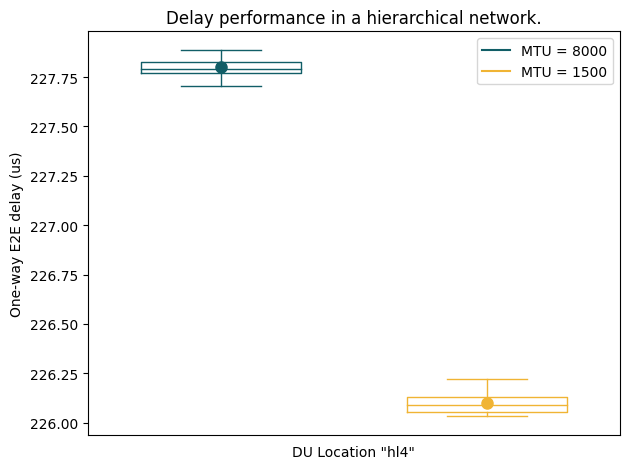

In [40]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  


colors = plt.cm.Set3.colors
plt.rcParams["figure.autolayout"] = True

folder = "../sim_results/"
DU_loc = ["hl4"]
mtu = [8000, 1500]
prop = "p"
modes = ["avg"]
Prop_del = 5
due2e = []


for i, du in enumerate(DU_loc):
    for mod in modes:
        e2e = []
        for mtusize in mtu:
            delay = []
            filename = f"{du}hl5-{mtusize}{prop}{mod}"
            if du == "hl4" or "HL4":
                nodes = 9
            else:
                nodes = 23
            for j in range(nodes):
                UTx = pd.read_csv(f"{folder+filename}{1}/TxFileSite1Sector{j}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                URx = pd.read_csv(f"{folder+filename}{1}/RxFileSite1User{j}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                min_len = min(len(UTx), len(URx))
                delay.append((URx["Time"].values[:min_len-1] - UTx["Time"].values[:min_len-1])*1e-9)
            e2e.append(np.concatenate(delay))    
            # Obtain the difference - T12 or T34
            diff_max_min = np.max(np.concatenate(e2e)) - np.min(np.concatenate(e2e))
            avg_val = np.average(np.concatenate(e2e))
            print(f"MTU: {mtusize}, DU: {du}, Max-Min delay: {diff_max_min:.2f} us, Avg. delay {avg_val:.2f} us")
        due2e.append(e2e)     
        
        
# Plotting
fig, ax = plt.subplots()
lw, lq, med, uq, uw, avg = [], [], [], [], [], []


for i, e2e_delays in enumerate(due2e):
    positions = [1 + i * 3, 2 + i * 3]
    bp = ax.boxplot(e2e_delays, positions=positions, widths=0.6, showmeans=True)
    setBoxColors(bp)

    lw.extend([w.get_ydata()[1] for w in bp['whiskers'][::2]])
    lq.extend([w.get_ydata()[0] for w in bp['whiskers'][::2]])
    med.extend([m.get_ydata()[1] for m in bp['medians']])
    uq.extend([w.get_ydata()[0] for w in bp['whiskers'][1::2]])
    uw.extend([w.get_ydata()[1] for w in bp['whiskers'][1::2]])
    avg.extend([m.get_ydata()[0] for m in bp['means']])

# Save boxplot stats to file
with open("boxplot_coordinates.txt", "w") as f:
    f.write("lw\tlq\tmed\tuq\tuw\tavg\n")
    for vals in zip(lw, lq, med, uq, uw, avg):
        f.write("\t".join(f"{v:.3f}" for v in vals) + "\n")

# Configure x-axis ticks and labels
ax.set_xticks(np.arange(3, 6 * len(DU_loc) + 1, 6))
ax.set_xticklabels(DU_loc)

# Legend example colors (define colors explicitly)

plt.plot([], c=green, label=f"MTU = {mtu[0]}")
plt.plot([], c=yellow, label=f"MTU = {mtu[1]}")

plt.title("Delay performance in a hierarchical network.")
plt.ylabel("One-way E2E delay (us)")
plt.xlabel(f"DU Location \"{du}\"")
plt.legend()
plt.show()